In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_sobol_dual_aligned_zero(
    names,
    S1, S1_conf,
    ST, ST_conf,
    title="Sobol S1 & ST (zero-aligned)",
    order_by="ST",           # "ST", "S1", or None
    clip_bars_at_zero=True,  # bars clipped to 0; error bars remain two-sided around the estimate
    rotate=45,
    out_path: str | Path | None = None,
):
    """
    Single figure: S1 and ST bars side-by-side per parameter, with *aligned zero baselines*.
    Achieved by plotting both onto the same axis and attaching a secondary y-axis that
    is a linear scaling of the primary axis (so 0 <-> 0 always).

    Inputs can be lists/arrays. S1_conf/ST_conf are confidence *half-widths* (as in SALib).
    """
    # --- pack, sort, and numpy-ize ---
    df = pd.DataFrame({
        "name": list(names),
        "S1":   np.asarray(S1, float),
        "S1c":  np.asarray(S1_conf, float),
        "ST":   np.asarray(ST, float),
        "STc":  np.asarray(ST_conf, float),
    })
    if order_by in ("S1", "ST"):
        df = df.sort_values(order_by, ascending=False, kind="mergesort").reset_index(drop=True)

    names = df["name"].tolist()
    S1  = df["S1"].to_numpy();  S1c = df["S1c"].to_numpy()
    ST  = df["ST"].to_numpy();  STc = df["STc"].to_numpy()

    # --- bar positions and widths ---
    x = np.arange(len(df), dtype=float)
    w = 0.40  # width of each bar

    # --- build bars (optionally clipped at 0), but keep two-sided CI around the estimate ---
    def bar_and_yerr(est, conf, clip):
        bar = np.maximum(est, 0.0) if clip else est.copy()
        lower_target = est - conf
        upper_target = est + conf
        # yerr expects distances from the plotted bar height to the CI ends
        lower = np.clip(bar - lower_target, 0.0, None)
        upper = np.clip(upper_target - bar, 0.0, None)
        return bar, np.vstack([lower, upper]), lower_target, upper_target

    S1_bar, S1_yerr, S1_low, S1_up = bar_and_yerr(S1, S1c, clip_bars_at_zero)
    ST_bar, ST_yerr, ST_low, ST_up = bar_and_yerr(ST, STc, clip_bars_at_zero)

    # --- compute a linear scale factor so ST fits the same canvas and 0 aligns with S1's 0 ---
    # span considered from the smallest target (could be <0) to the largest target (>0)
    S1_min = min(0.0, float(np.min(S1_low)))
    S1_max = max(float(np.max(S1_up)), 0.0)
    ST_min = min(0.0, float(np.min(ST_low)))
    ST_max = max(float(np.max(ST_up)), 0.0)

    # guard against degenerate spans
    S1_span = max(S1_max - S1_min, 1e-12)
    ST_span = max(ST_max - ST_min, 1e-12)

    # ST is mapped onto primary axis by dividing by 'a'
    a = ST_span / S1_span

    # scale ST bar heights & error bars to S1 units
    ST_bar_scaled = ST_bar / a
    ST_yerr_scaled = ST_yerr / a

    # --- plotting (both series on the SAME axis) ---
    fig, ax = plt.subplots(figsize=(max(8, 0.7*len(df)), 5))

    b1 = ax.bar(x - w/2, S1_bar, width=w, yerr=S1_yerr, capsize=3, label="S1")
    b2 = ax.bar(x + w/2, ST_bar_scaled, width=w, yerr=ST_yerr_scaled, capsize=3, label="ST", alpha=0.9)

    # primary axis for S1
    ax.set_ylabel("S1")
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=rotate, ha="right")
    ax.grid(axis="y", alpha=0.25)
    ax.set_title(title)

    # primary axis limits (include S1 CI targets and scaled ST CI targets)
    ymin = min(S1_min, ST_min / a, 0.0)
    ymax = max(S1_max, ST_max / a, np.max(S1_bar), np.max(ST_bar_scaled), 1e-12)
    ax.set_ylim(0, ymax+0.05)

    # secondary y-axis that maps primary units -> ST units by y2 = a * y1 (0->0)
    secax = ax.secondary_yaxis('right', functions=(lambda y: a*y, lambda y: y/a))
    secax.set_ylabel("ST")

    # legend
    ax.legend([b1, b2], ["S1 (main effect)", "ST (total effect)"], loc="upper right", frameon=False)

    plt.tight_layout()
    if out_path is not None:
        out_path = Path(out_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
    return fig, (ax, secax)




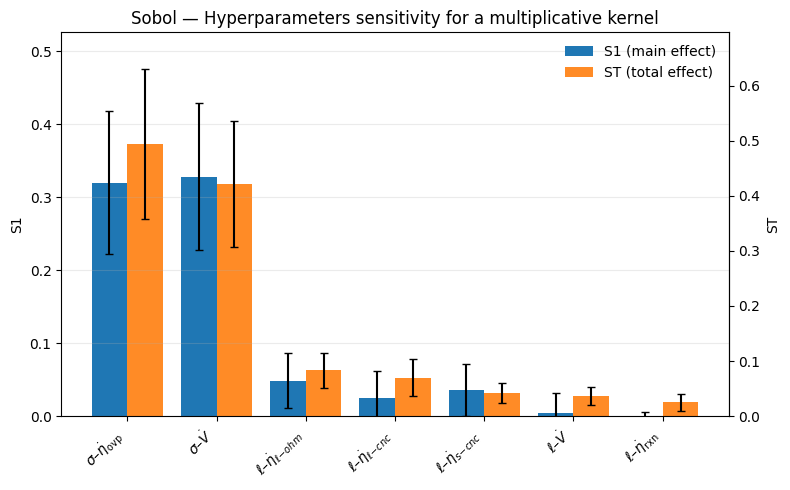

In [19]:
# --- minimal demo with your numbers (run this block to see it) ---
names_ex = [
    "$\ell$–$\dot{V}$","$\sigma$–$\dot{V}$",
    "$\ell$–$\dot{\eta}_{\mathrm{rxn}}$","$\ell$–$\dot{\eta}_{s{-}cnc}$","$\ell$–$\dot{\eta}_{\ell{-}cnc}$","$\ell$–$\dot{\eta}_{\ell{-}ohm}$",
    "$\sigma$–$\dot{\eta}_{\mathrm{ovp}}$",
]
"""    
    "kV_lengthscale":        r"$\ell$–$\dot{V}$",
    "kV_variance":           r"$\sigma$–$\dot{V}$",
    "k1_lengthscale_1":      r"$\ell$–$\dot{\eta}_{\mathrm{rxn}}$",
    "k1_lengthscale_2":      r"$\ell$–$\dot{\eta}_{s{-}cnc}$",
    "k1_lengthscale_3":      r"$\ell$–$\dot{\eta}_{l{-}cnc}$",
    "k1_lengthscale_4":      r"$\ell$–$\dot{\eta}_{l{-}ohm}$",
    "k1_variance":           r"$\sigma$–$\dot{\eta}_{\mathrm{ovp}}$",
    
"""
S1_ex  = [0.00447251, 0.32804056, -0.02065522, 0.03619131, 0.02541518, 0.04881321, 0.31998116]
S1c_ex = [0.0269394,  0.10098558, 0.02618399,  0.03584633, 0.03699158, 0.0380181,  0.09847247]
ST_ex  = [0.03641846, 0.42071731, 0.02519467,  0.04186572, 0.07010522, 0.08334224, 0.49439916]
STc_ex = [0.01599296, 0.11444029, 0.01553735,  0.01884587, 0.0330136,  0.03165433, 0.13598131]

fig, axes = plot_sobol_dual_aligned_zero(names_ex, S1_ex, S1c_ex, ST_ex, STc_ex,
     title="Sobol — Hyperparameters sensitivity for a multiplicative kernel",
     order_by="ST", clip_bars_at_zero=True)


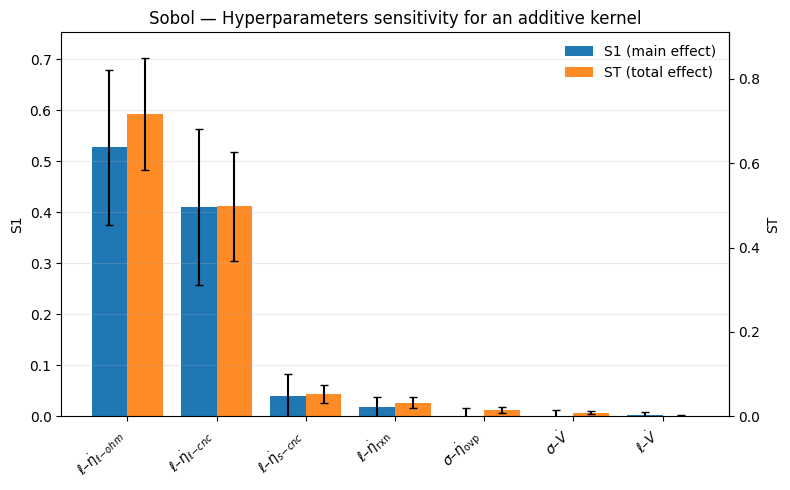

In [21]:
# --- minimal demo with your numbers (run this block to see it) ---
names_ex = [
    "$\ell$–$\dot{V}$","$\sigma$–$\dot{V}$",
    "$\ell$–$\dot{\eta}_{\mathrm{rxn}}$","$\ell$–$\dot{\eta}_{s{-}cnc}$","$\ell$–$\dot{\eta}_{\ell{-}cnc}$","$\ell$–$\dot{\eta}_{\ell{-}ohm}$",
    "$\sigma$–$\dot{\eta}_{\mathrm{ovp}}$",
]
"""    
    "kV_lengthscale":        r"$\ell$–$\dot{V}$",
    "kV_variance":           r"$\sigma$–$\dot{V}$",
    "k1_lengthscale_1":      r"$\ell$–$\dot{\eta}_{\mathrm{rxn}}$",
    "k1_lengthscale_2":      r"$\ell$–$\dot{\eta}_{s{-}cnc}$",
    "k1_lengthscale_3":      r"$\ell$–$\dot{\eta}_{l{-}cnc}$",
    "k1_lengthscale_4":      r"$\ell$–$\dot{\eta}_{l{-}ohm}$",
    "k1_variance":           r"$\sigma$–$\dot{\eta}_{\mathrm{ovp}}$",
    
"""
S1_ex  = [
        0.00268512,
       -0.00200534,
        0.01821534,
        0.03982712,
        0.40974537,
        0.52696959,
       -0.00333238,
    ]
S1c_ex = [
        0.00546373,
        0.01448975,
        0.0196325,
        0.04261876,
        0.15292213,
        0.15241789,
        0.0195715,
    ]
ST_ex  = [
        0.00101947,
        0.00820131,
        0.03182934,
        0.05216189,
        0.49745345,
        0.71683033,
        0.01439679,
    ]
STc_ex = [
        0.00067914,
        0.00432344,
        0.01326943,
        0.02095224,
        0.13024854,
        0.13314249,
        0.00636509,
    ]


fig, axes = plot_sobol_dual_aligned_zero(names_ex, S1_ex, S1c_ex, ST_ex, STc_ex,
     title="Sobol — Hyperparameters sensitivity for an additive kernel",
     order_by="ST", clip_bars_at_zero=True)


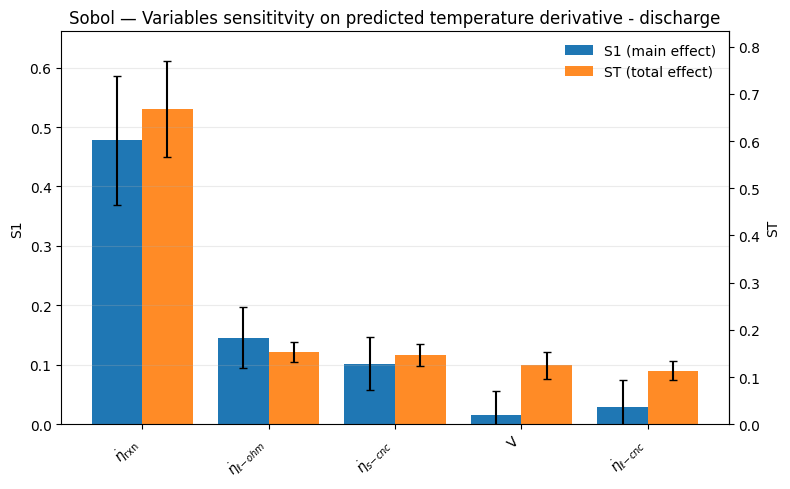

In [26]:
names = [
    "V",
    "$\dot{\eta}_{\mathrm{rxn}}$",
    "$\dot{\eta}_{s{-}cnc}$",
    "$\dot{\eta}_{\ell{-}cnc}$",
    "$\dot{\eta}_{\ell{-}ohm}$",
]

S1 = [
    0.01508141,
    0.47759888,
    0.10179519,
    0.02886829,
    0.14583048,
]

S1_conf = [
    0.0403793,
    0.10816515,
    0.04460328,
    0.0463825,
    0.05090691,
]

ST = [
    0.12448344,
    0.66760592,
    0.14731523,
    0.11383612,
    0.1529472,
]

ST_conf = [
    0.02762485,
    0.10207507,
    0.02367697,
    0.02032331,
    0.02047276,
]

fig, axes = plot_sobol_dual_aligned_zero(names, S1, S1_conf, ST, ST_conf,
     title="Sobol — Variables sensititvity on predicted temperature derivative - discharge",
     order_by="ST", clip_bars_at_zero=True)


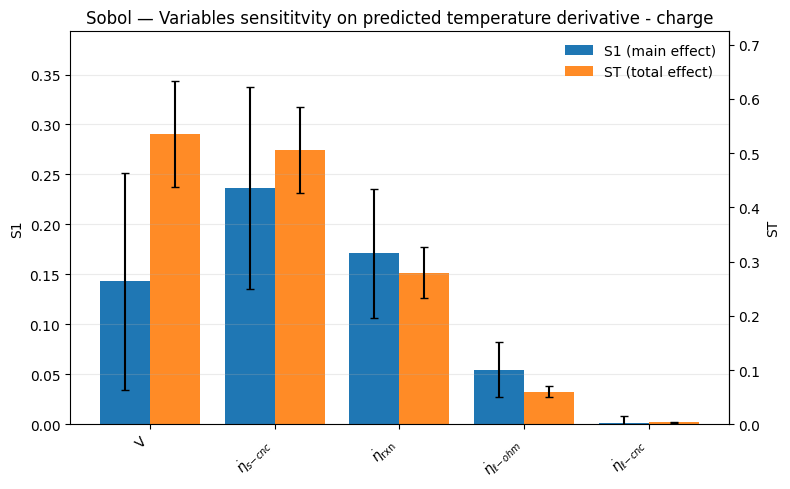

In [27]:
names = [
    "V",
    "$\dot{\eta}_{\mathrm{rxn}}$",
    "$\dot{\eta}_{s{-}cnc}$",
    "$\dot{\eta}_{\ell{-}cnc}$",
    "$\dot{\eta}_{\ell{-}ohm}$",
]

S1 = [
    0.14297899,
    0.17116929,
    0.23603947,
    0.00104664,
    0.05471645,
]

S1_conf = [
    0.10835569,
    0.06448266,
    0.10113975,
    0.00706843,
    0.02749502,
]

ST = [
    0.53543785,
    0.2792363,
    0.5053797,
    0.00345875,
    0.06008736,
]

ST_conf = [
    0.09704505,
    0.04701809,
    0.07978544,
    0.00066857,
    0.00981801,
]

fig, axes = plot_sobol_dual_aligned_zero(names, S1, S1_conf, ST, ST_conf,
     title="Sobol — Variables sensititvity on predicted temperature derivative - charge",
     order_by="ST", clip_bars_at_zero=True)
